# Question: How do annual members and casual riders use Cyclistic bikes differently?

## Preprocessing:
1. Deal with duplicate/ missing/ unusual values
2. Drop unnecessary columns
3. Parse the datetime
4. caluate the length of ride and travel distance

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy import distance

In [74]:
data = os.listdir('./data/')
print(data)

['202011-divvy-tripdata.csv', '202104-divvy-tripdata.csv', '.DS_Store', '202012-divvy-tripdata.csv', '202004-divvy-tripdata.csv', '202009-divvy-tripdata.csv', '202101-divvy-tripdata.csv', '202102-divvy-tripdata.csv', '202007-divvy-tripdata.csv', '202103-divvy-tripdata.csv', '202006-divvy-tripdata.csv', '202005-divvy-tripdata.csv', '202008-divvy-tripdata.csv', '202010-divvy-tripdata.csv']


In [75]:
#combine all csv files into one 
df = pd.read_csv('./data/' + data[0])
count = 1
for file in data[1::]:
    # as there are data of April 2020 and April 2021, 
    # decided to use the most recent record, 
    # skip data of April 2020 to maintain data of 1 year.
    if file == '202004-divvy-tripdata.csv' or file == '.DS_Store':
        continue
    path = './data/' + file
    df_temp = pd.read_csv(path)
    df = pd.concat([df, df_temp])
    count += 1
print(count == len(os.listdir('./data/')) - 2)

True


In [76]:
df.shape

(3742202, 13)

In [6]:
df.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

In [4]:
#glimpse the combined trip data
df.sample(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
99100,63229F92C299E973,classic_bike,2021-04-21 13:08:45,2021-04-21 13:11:56,May St & Taylor St,13160,900 W Harrison St,13028,41.869482,-87.655486,41.874754,-87.649807,member
516610,D7FBCC843DD8FCF3,docked_bike,2020-07-12 13:51:45,2020-07-12 14:14:56,Spaulding Ave & Division St,510,Marshfield Ave & Cortland St,58,41.902706,-87.709219,41.916017,-87.668879,casual
168992,A92123FDB7A91CCD,docked_bike,2020-06-28 11:51:53,2020-06-28 12:17:16,Theater on the Lake,177,Theater on the Lake,177,41.926277,-87.630834,41.926277,-87.630834,casual
216643,2E6DDA6827592BC2,electric_bike,2020-11-04 09:43:46,2020-11-04 09:47:07,McClurg Ct & Erie St,142,NaN,NaN,41.894294,-87.618223,41.900000,-87.620000,member
458607,4EEC8C17E88DD8E2,docked_bike,2020-08-03 19:24:56,2020-08-03 19:39:40,Leavitt St & Belmont Ave,664,Ravenswood Ave & Lawrence Ave,344,41.939354,-87.683282,41.969090,-87.674237,casual


In [41]:
# There are duplicated entries
df.duplicated('ride_id').any()

True

In [45]:
# it seems station_id is different in duplicated entries
df[df.duplicated('ride_id',keep=False)].sort_values(by=['ride_id']).head(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
23285,021A73F8C18B932D,docked_bike,2020-12-15 12:15:58,2020-11-25 16:48:02,Clark St & Winnemac Ave,TA1309000035,Ravenswood Ave & Berteau Ave,TA1309000018,41.973347,-87.667855,41.957921,-87.673567,member
106076,021A73F8C18B932D,docked_bike,2020-11-25 16:35:39,2020-11-25 16:48:02,Clark St & Winnemac Ave,325,Ravenswood Ave & Berteau Ave,314,41.973347,-87.667855,41.957921,-87.673567,member
74015,0334987B57662109,docked_bike,2020-11-25 16:15:04,2020-11-25 16:22:04,Broadway & Berwyn Ave,294,Lakefront Trail & Bryn Mawr Ave,459,41.978353,-87.659753,41.984037,-87.652310,member
37161,0334987B57662109,docked_bike,2020-12-15 11:56:33,2020-11-25 16:22:04,Broadway & Berwyn Ave,13109,Lakefront Trail & Bryn Mawr Ave,KA1504000152,41.978353,-87.659753,41.984037,-87.652310,member
46936,038CAB4A84D9A56B,docked_bike,2020-12-15 11:57:41,2020-11-25 16:24:56,Wabash Ave & 9th St,TA1309000010,Wabash Ave & 9th St,TA1309000010,41.870769,-87.625734,41.870769,-87.625734,member
57814,038CAB4A84D9A56B,docked_bike,2020-11-25 16:08:05,2020-11-25 16:24:56,Wabash Ave & 9th St,321,Wabash Ave & 9th St,321,41.870769,-87.625734,41.870769,-87.625734,member
99418,0425DA22910BD202,docked_bike,2020-12-15 11:37:02,2020-11-25 08:49:25,Desplaines St & Jackson Blvd,15539,Stetson Ave & South Water St,TA1308000029,41.878287,-87.643909,41.886835,-87.622320,member
71397,0425DA22910BD202,docked_bike,2020-11-25 08:32:26,2020-11-25 08:49:25,Desplaines St & Jackson Blvd,107,Stetson Ave & South Water St,264,41.878287,-87.643909,41.886835,-87.622320,member
114812,05498BABECEB55B0,docked_bike,2020-12-15 12:11:52,2020-11-25 08:51:27,Clinton St & Madison St,TA1305000032,Cityfront Plaza Dr & Pioneer Ct,13427,41.882242,-87.641066,41.890573,-87.622072,member
240078,05498BABECEB55B0,docked_bike,2020-11-25 08:42:12,2020-11-25 08:51:27,Clinton St & Madison St,77,Cityfront Plaza Dr & Pioneer Ct,196,41.882242,-87.641066,41.890573,-87.622072,member


In [46]:
# drop the duplicated
df.drop_duplicates('ride_id', keep='first', inplace=True)

In [47]:
# convert to datetime 
df.started_at = pd.to_datetime(df.started_at)
df.ended_at = pd.to_datetime(df.ended_at)

In [48]:
# there are unusual records
# ended_at shall not be earlier than started_at
# besides this, we are to exclude those record that ended_at == started_at
(df['started_at'] >= df['ended_at']).value_counts()

False    3731285
True       10708
dtype: int64

In [49]:
# filter out unusual records
df2 = df[(df['started_at'] < df['ended_at'])].copy()
def df

In [50]:
#keep only necessary columns
df2.drop(['ride_id','start_station_id', 'end_station_id', 'start_station_name', 'end_station_name'], 
         axis=1, inplace=True)

In [53]:
# check missing values
df2.isna().any()

rideable_type    False
started_at       False
ended_at         False
start_lat        False
start_lng        False
end_lat           True
end_lng           True
member_casual    False
dtype: bool

In [51]:
# less than 2% of data is missing 
miss = {}
for i in df2.columns:
    miss[i] = round((df2.shape[0] - df2[i].count())/ df2.shape[0] * 100, 2)
miss

{'rideable_type': 0.0,
 'started_at': 0.0,
 'ended_at': 0.0,
 'start_lat': 0.0,
 'start_lng': 0.0,
 'end_lat': 0.13,
 'end_lng': 0.13,
 'member_casual': 0.0}

In [54]:
# drop missing values 
df2.dropna(inplace=True)

In [55]:
# parsing date and time
df2['weekday'] = df2.started_at.dt.day_name()
df2['month'] = df2.started_at.dt.month
#df2['day'] = df2.started_at.dt.day
df2['start_hr'] = df2.started_at.dt.hour
df2['end_hr'] = df2.ended_at.dt.hour
#df2['use_time(sec)'] = (df2['ended_at'] - df2['started_at']).dt.seconds
df2['use_time(min)'] = round((df2['ended_at'] - df2['started_at']).dt.total_seconds()/60, 2)
df2['use_time(hr)'] = round((df2['ended_at'] - df2['started_at']).dt.total_seconds()/60/60, 2)

In [56]:
# get the travel distance
def cal_dist(x1,y1,x2,y2):
    return distance.distance((x1,y1), (x2,y2)).km

In [57]:
df2['travel_distance(km)'] = df2[['start_lat','start_lng',
                              'end_lat','end_lng']].apply(lambda x: cal_dist(*x), axis=1)

In [58]:
# limitation: some riders may return the bikes at the same place where they started, 
# in this case the distance will be zero even though they do ride for a few meters
# less than 9% of the observations are of 0 travel distance, decided to keep those observations
round(df2[df2['travel_distance(km)'] == 0].shape[0] / df2.shape[0] * 100, 2)

8.61

In [60]:
df2.sample(5)

,rideable_type,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,member_casual,weekday,month,start_hr,end_hr,use_time(min),use_time(hr),travel_distance(km)
152366,docked_bike,2020-10-03 17:37:15,2020-10-03 17:46:19,41.956057,-87.668835,41.944540,-87.654678,member,Saturday,10,17,17,9.07,0.15,1.736169
225760,classic_bike,2021-04-18 19:19:21,2021-04-18 19:34:12,41.891847,-87.620580,41.904613,-87.640552,casual,Sunday,4,19,19,14.85,0.25,2.181081
486465,docked_bike,2020-07-12 16:43:54,2020-07-12 17:01:21,41.933140,-87.647760,41.928773,-87.663913,casual,Sunday,7,16,17,17.45,0.29,1.424838
188496,docked_bike,2020-08-19 18:48:45,2020-08-19 18:49:06,41.831379,-87.618034,41.831379,-87.618034,casual,Wednesday,8,18,18,0.35,0.01,0.000000
183486,docked_bike,2020-07-01 17:41:56,2020-07-01 18:03:05,41.948150,-87.663940,41.919936,-87.648830,casual,Wednesday,7,17,18,21.15,0.35,3.375061


In [59]:
# back up
df2.to_csv('cleaned.csv', index_label=False)

In [10]:
df2 = pd.read_csv('cleaned.csv')
df2.started_at = pd.to_datetime(df2.started_at)
df2.ended_at = pd.to_datetime(df2.ended_at)

## Plots
1. rides by month
2. rides by weekdays
3. use time by weekdays
4. travel distance
5. choice of bikes 

In [61]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["axes.titlesize"] = 20
plt.rcParams['font.size'] = 15

Text(0.5, 1.0, 'Number of Rides according to Member Type')

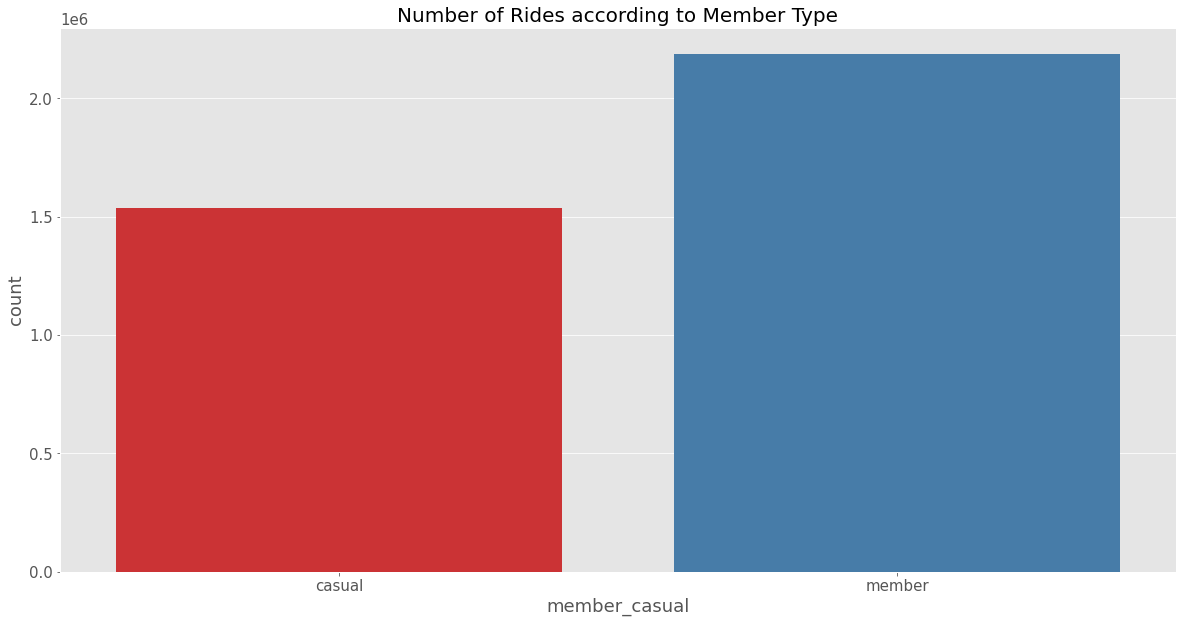

In [62]:
sns.countplot(x='member_casual', data=df2, palette="Set1").set_title("Number of Rides according to Member Type")

Text(0.5, 1.0, 'Number of Rides by Months')

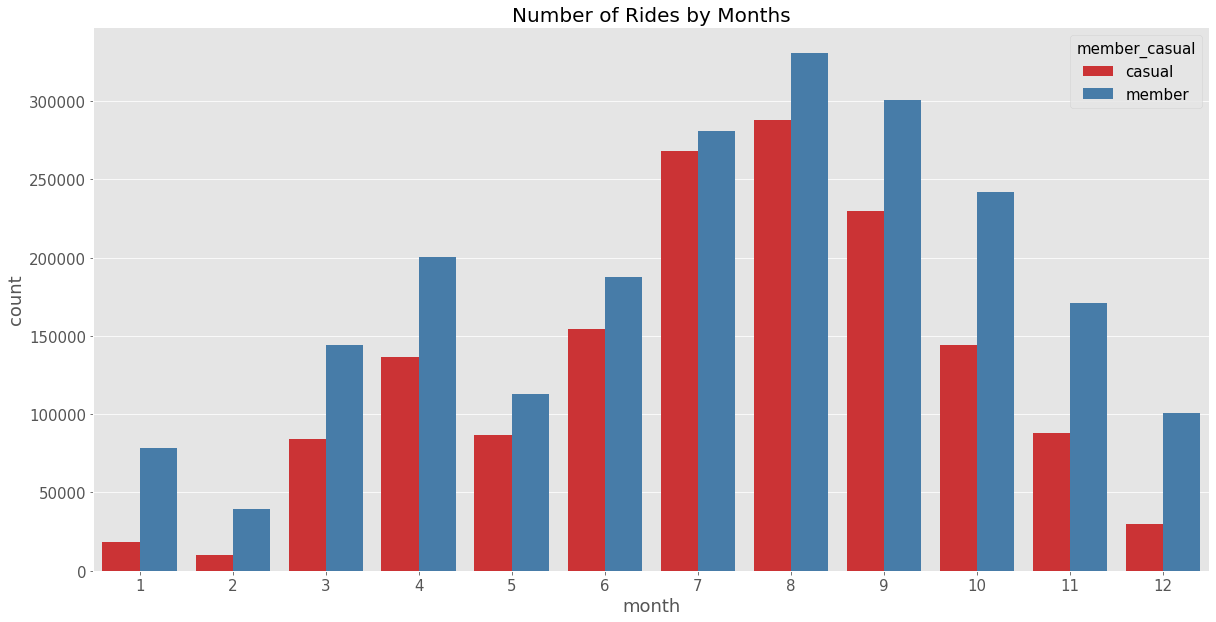

In [63]:
# Seasonal difference applies to both causal users and members.
sns.countplot(x='month', data=df2, hue='member_casual', palette="Set1").set_title("Number of Rides by Months")

Text(0.5, 1.0, 'Number of Rides by Weekdays')

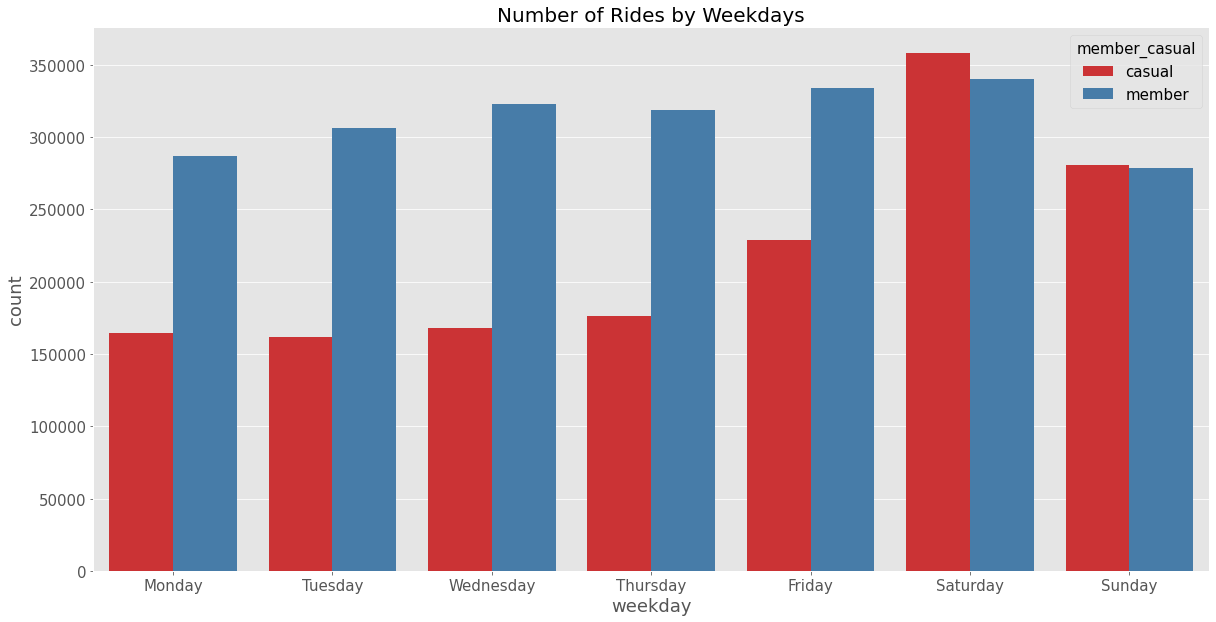

In [64]:
# the pattern of members using a bike spreads relatively even over the weekdays
# there is an increase in use by casual users on weekends, the total ride is even more than members'
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.countplot(x='weekday', data=df2, hue='member_casual',
              order=day_order, palette="Set1").set_title('Number of Rides by Weekdays')

Text(0.5, 1.0, 'Average Use Time (in minutes) by Weekday')

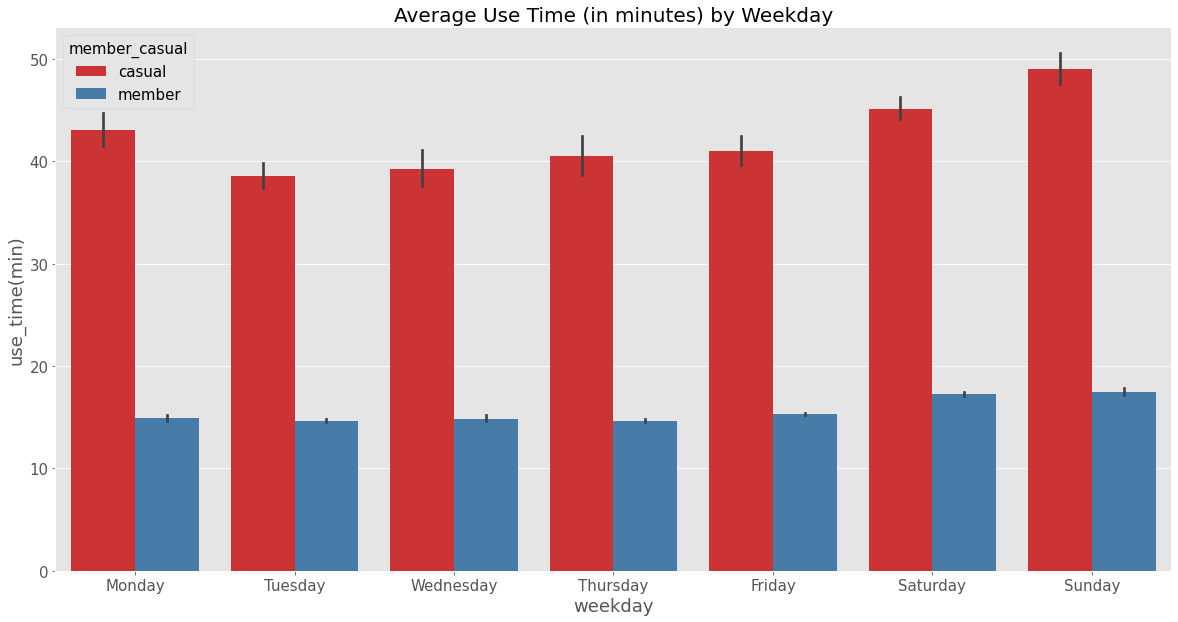

In [65]:
# The average use time of a ride reveals that members use bikes regularly for around 15 minutes,
# whereas causal users ride for at least 39 minutes in average.
sns.barplot(x='weekday', y='use_time(min)', data=df2, 
            hue='member_casual',order=day_order, 
            palette="Set1").set_title('Average Use Time (in minutes) by Weekday')

Text(0.5, 1.0, 'Average Travel Distance (km) by Weekday')

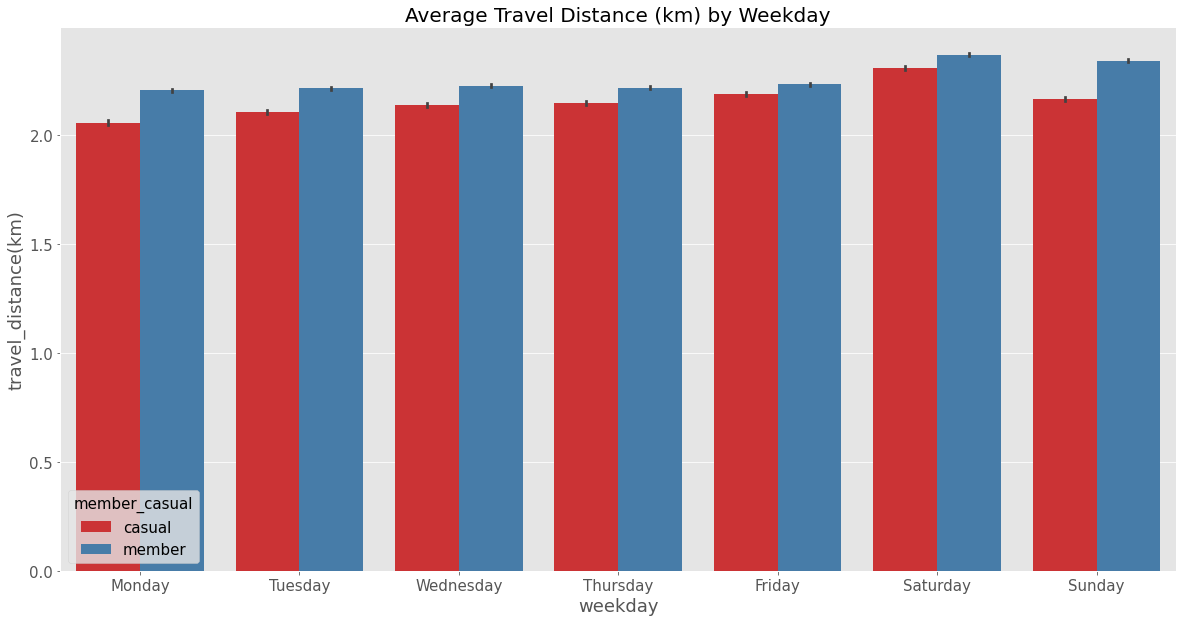

In [66]:
# Travel distance of rides are of little difference between members and casual users
# however, the previous plot shows that casual users ride for longer time in average, 
# members ride in higher speed and straight to destination.
sns.barplot(x='weekday', y='travel_distance(km)', data=df2, 
            hue='member_casual',order=day_order, 
            palette="Set1").set_title('Average Travel Distance (km) by Weekday')

Text(0.5, 1.0, 'Ride Duration')

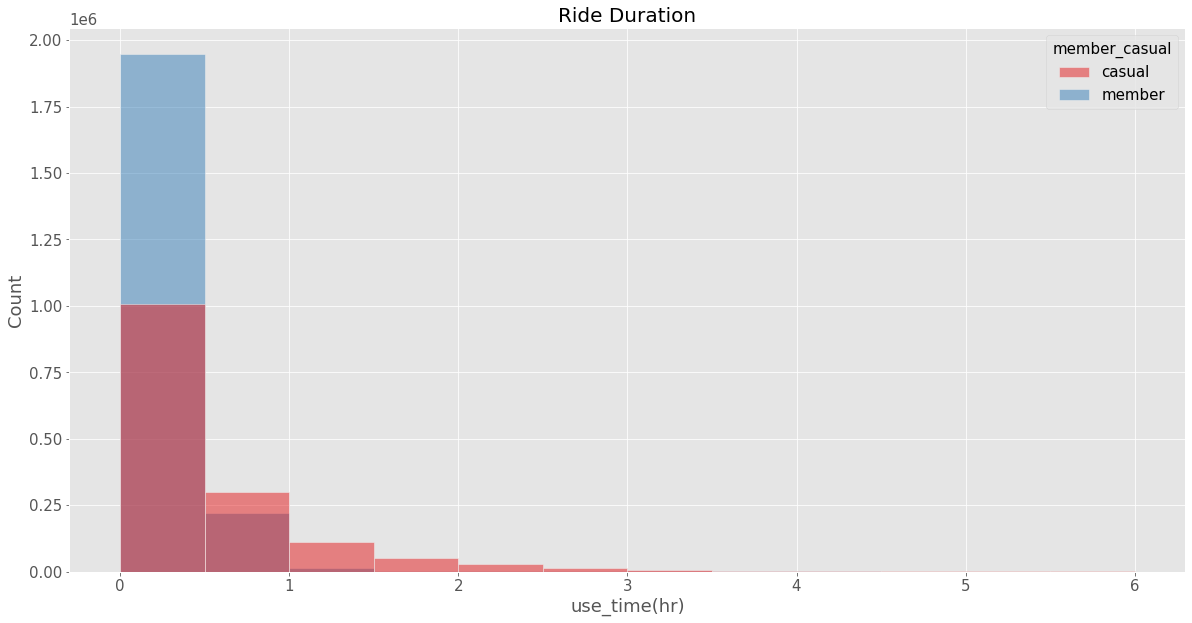

In [67]:
# most of the members ride for less than half an hour
sns.histplot(x='use_time(hr)', data=df2, hue='member_casual',
            palette="Set1", binwidth=0.5, binrange=(0,6)).set_title('Ride Duration')

Text(0.5, 1.0, 'Rides by Start Hour')

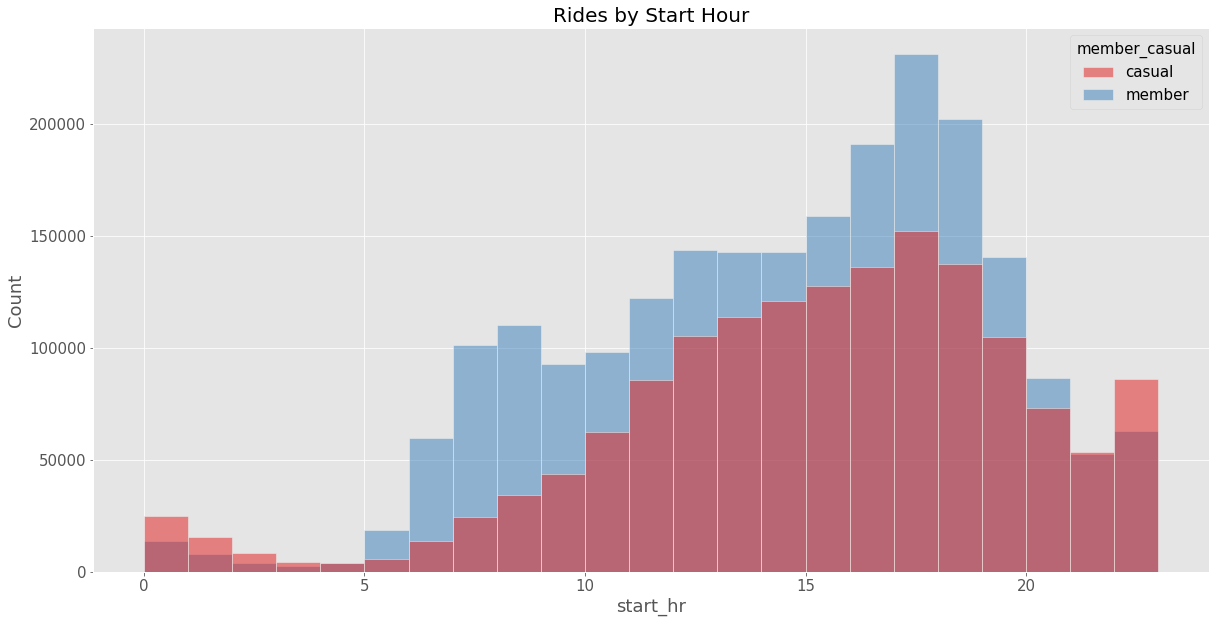

In [68]:
# Member seldom ride after midnight
# Some members may ride regularly to workplace and back home as there are increases in periods 6-9am and 5-6pm
sns.histplot(x='start_hr', data=df2, hue='member_casual', 
             palette="Set1", binwidth=1).set_title('Rides by Start Hour')

Text(0.5, 1.0, 'Average Travel Distance(km)')

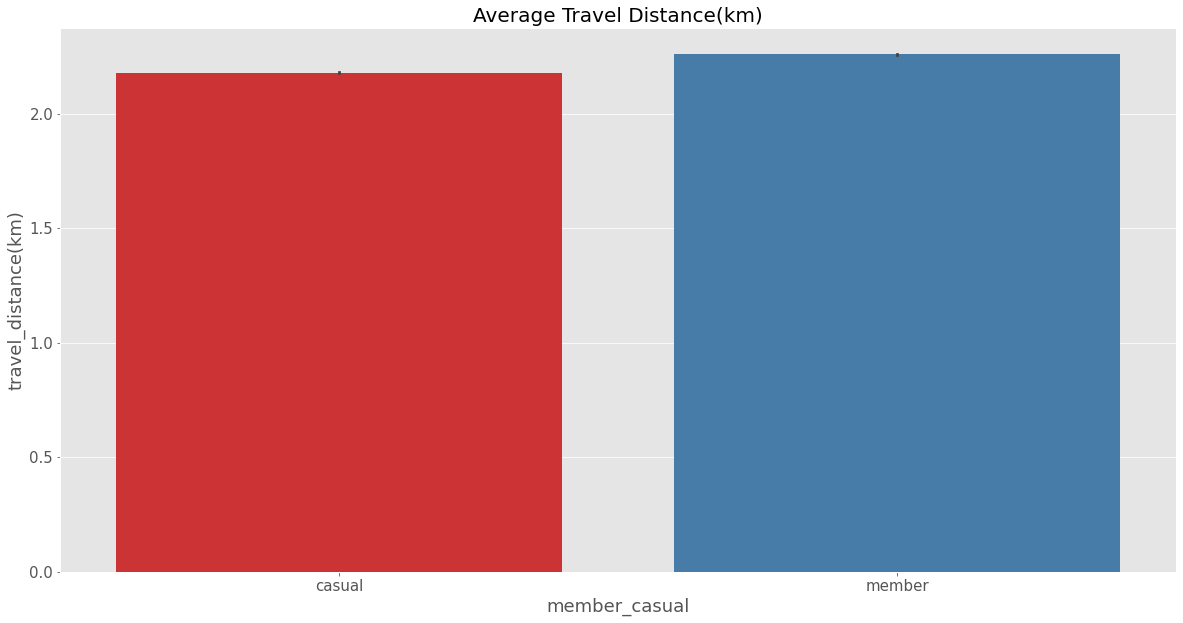

In [69]:
# Average travel distance is similar
sns.barplot(x='member_casual', y='travel_distance(km)', data=df2, 
            palette="Set1").set_title('Average Travel Distance(km)')

Text(0.5, 1.0, 'Travel Distance(km) Count')

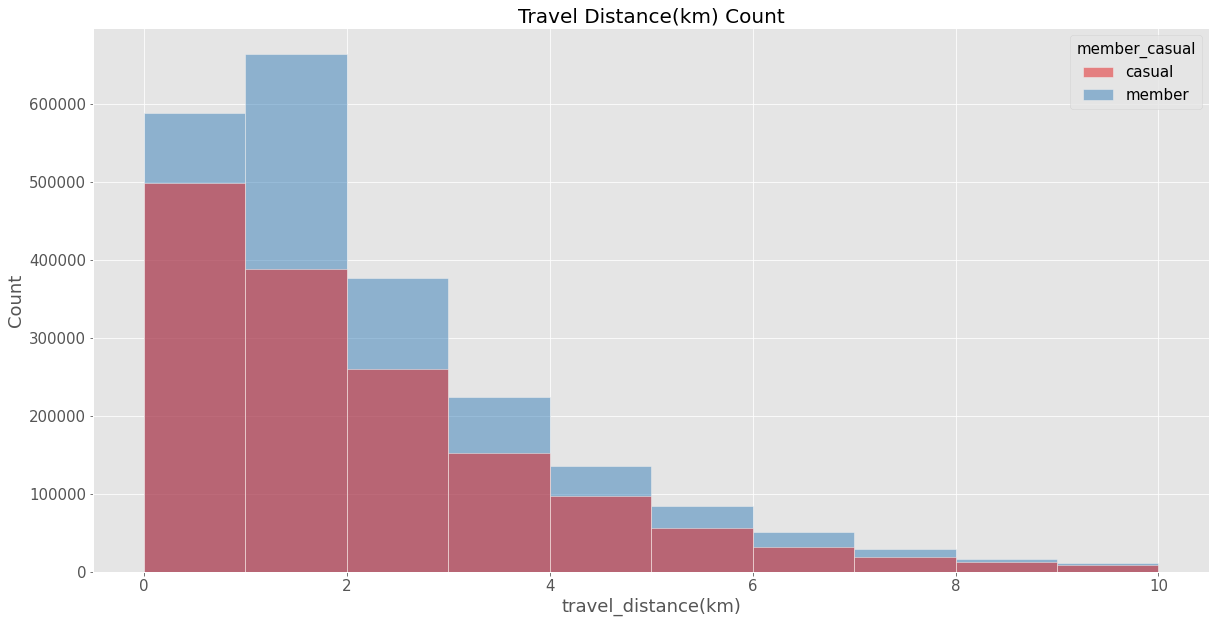

In [70]:
# Casual users usally ride for less than 1 km and the number of rides decreases as the distance increases
# Members tend to ride for 1-2 km 
sns.histplot(x='travel_distance(km)', data=df2, hue='member_casual', 
             palette="Set1", binwidth=1, binrange=(0,10)).set_title('Travel Distance(km) Count')

Text(0.5, 1.0, 'Choice of Bikes')

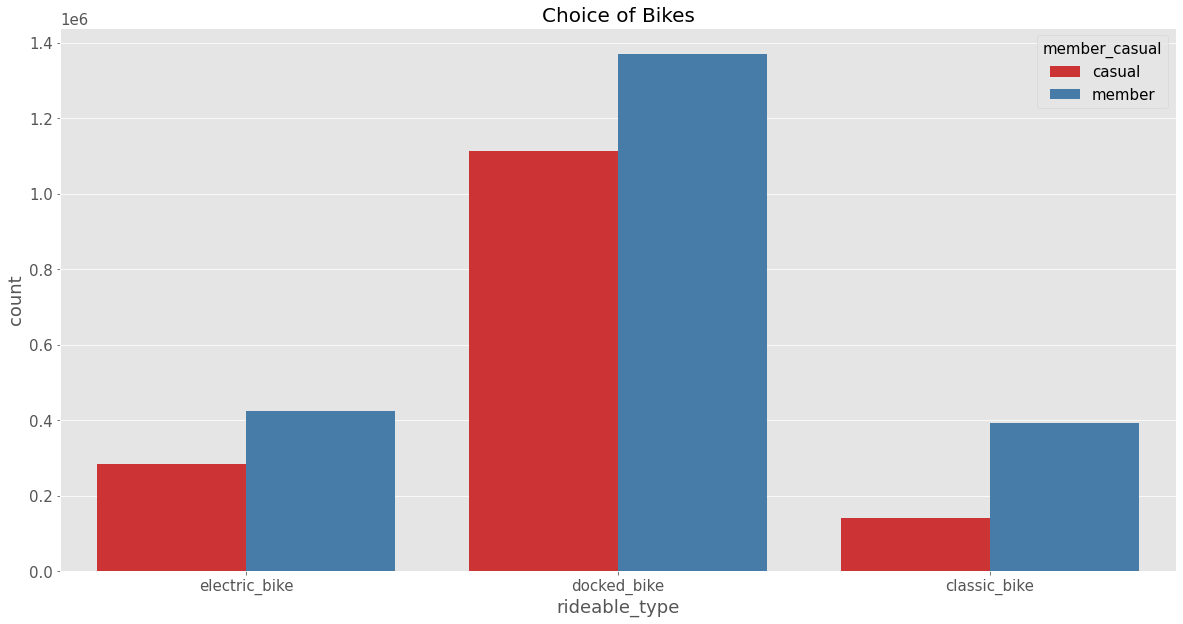

In [71]:
# Preference of bike is similar
sns.countplot(x='rideable_type', hue='member_casual', data=df2, palette="Set1").set_title('Choice of Bikes')

## To conclude:
### Members tend to:
1. ride regularly & return the bikes in around 15 mins
2. ride in higher speed and straight to destination
3. ride as a mean to commute between home and office